# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека, для обучения модели будем использовать набор фотографий людей с указанием их возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PATH = '/datasets/faces/'

In [3]:
labels = pd.read_csv(PATH + 'labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.shape

(7591, 2)

Датасет состоит из 7,5 тысяч фотографий с указанием возраста, посмторим как распределются значения возраста в нашем датасете.

In [7]:
labels['real_age'].median()

29.0

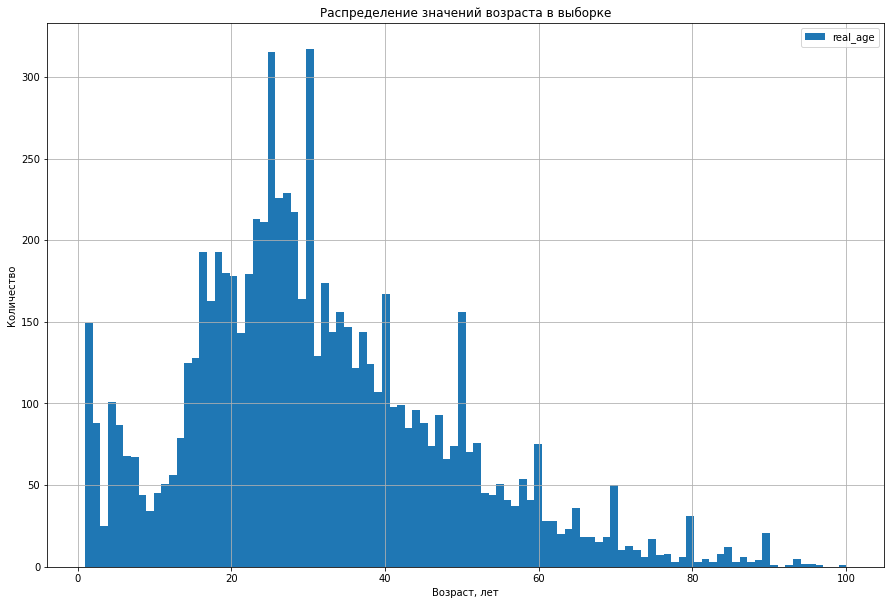

In [5]:
labels.plot(kind='hist', label='Возраст', figsize=(15,10),bins=100, grid=True)
plt.title('Распределение значений возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')
plt.show()

Медианный возраст людей на фотографиях - 29 лет, остальные значения возраста нормально распределены. 

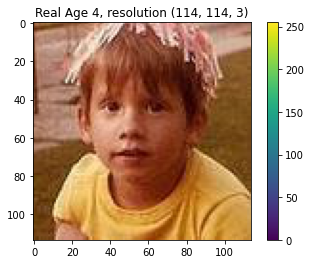

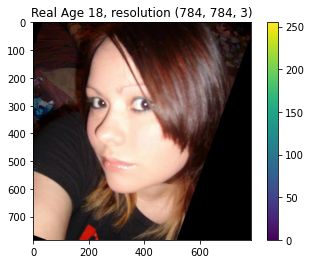

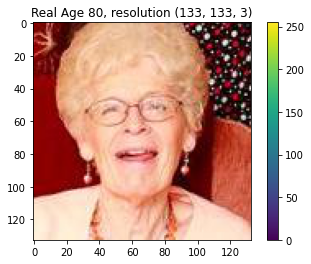

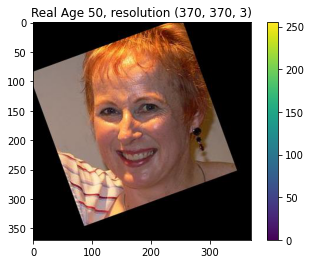

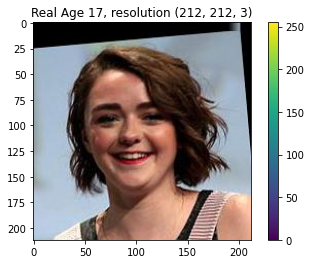

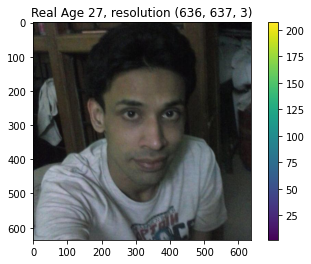

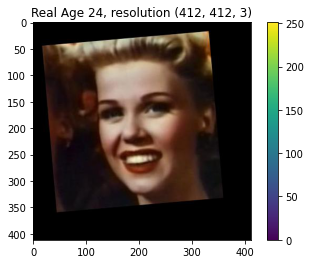

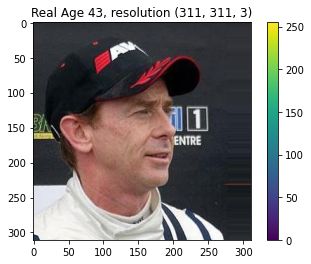

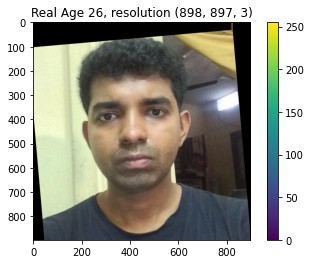

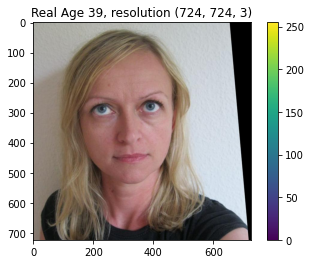

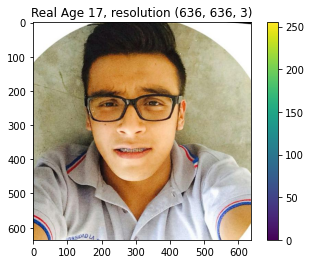

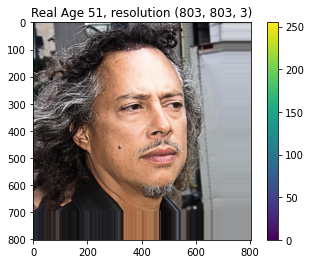

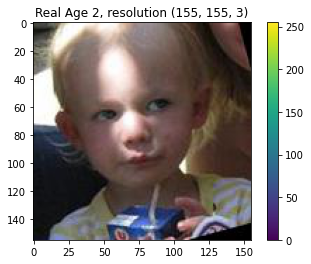

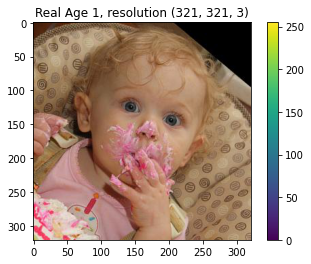

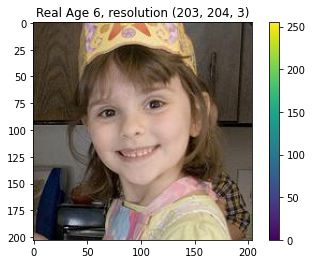

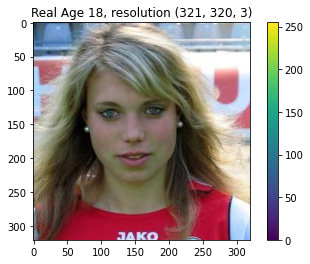

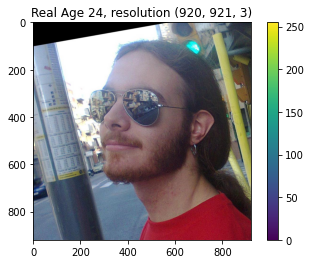

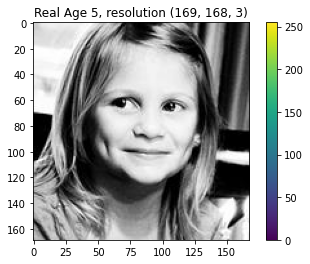

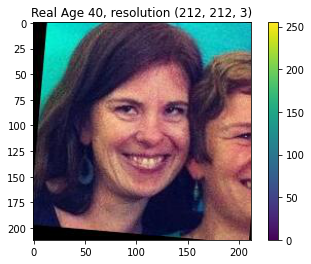

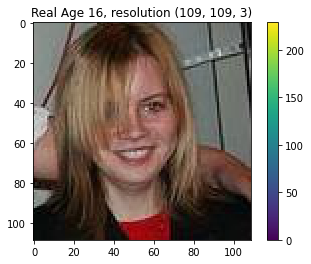

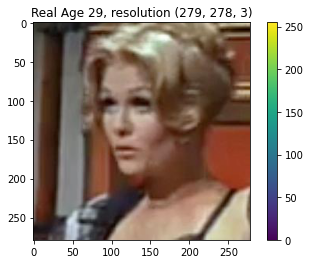

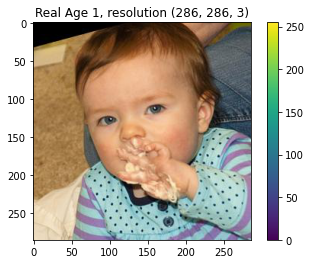

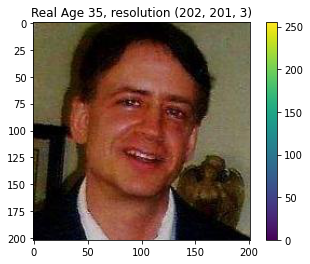

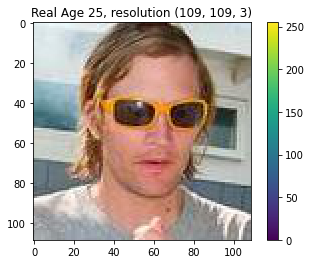

In [18]:
for i, age in zip(labels['file_name'][:24],labels['real_age'][:24]):
    image = Image.open('/datasets/faces/final_files/'+i)
    array = np.array(image)
    plt.imshow(array)
    plt.title(f'Real Age {age}, resolution {array.shape}')
    plt.colorbar()
    plt.show()

Фотографии в датасете квадратного формата и трёхканальные, но имееют различное разрешение от 100 до 900 точек на сторону, чтобы ускорить обучение модели ограничим размер фотографий до 224 точек на сторону. Кроме того можно заметить что некоторые фотографии повернуты, сдвинуты, растянуты и т.д., а на некоторых фотографиях лица изображены в профиль - все эти факторы усложнят обучение модели.

## Обучение модели

Приведённый ниже код был использован, для обучения модели на GPU тренажёре.

```python

import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       brightness_range=(0.8, 1.))

    train_data = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory=path + 'final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   subset='training',
                                                   seed=12345)

    return train_data

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.25)
    test_data = test_datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path + 'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='raw',
                                                 subset='validation',
                                                 seed=12345)

    return test_data


def create_model(input_shape):
    optimizer = Adam(lr=0.0003)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=6,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

По завершению обучения модели были получены следующие результаты:

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.


Epoch 1/6
178/178 - 59s - loss: 187.5414 - mae: 10.0937 - val_loss: 714.3696 - val_mae: 21.7672
Epoch 2/6
178/178 - 51s - loss: 92.6164 - mae: 7.2514 - val_loss: 578.2787 - val_mae: 18.9434
Epoch 3/6
178/178 - 51s - loss: 67.1069 - mae: 6.2180 - val_loss: 248.9742 - val_mae: 11.8422
Epoch 4/6
178/178 - 51s - loss: 51.2688 - mae: 5.4434 - val_loss: 114.6064 - val_mae: 8.2407
Epoch 5/6
178/178 - 51s - loss: 41.5310 - mae: 4.9460 - val_loss: 83.1858 - val_mae: 6.8145
Epoch 6/6
178/178 - 51s - loss: 33.0900 - mae: 4.3893 - val_loss: 76.3865 - val_mae: 6.5746

60/60 - 10s - loss: 76.3865 - mae: 6.5746
Test MAE: 6.5746

```

## Анализ обученной модели

1. Средняя ошибка в определении возраста оставила 6.5 лет.
1. Обучение модели на целевом уровне было произведено достаточно быстро и не потребовало значительных вычислительных мощностей. 
1. Точности такого уровня вполне достаточно для рекомендательной системы, особенно если добавить к этой модели определение пола покупателя.
1. Для контроля продажи алкоголя точности модели не достаточно, т.к. лица 12-13 лет могут быть приняты такой моделью за совершеннолетних.
1. Прежде чем применить такую модель для контроля продажи алкоголя, её качество необходимо улучшить, чтобы средняя ошибка составляла менее 1 года.